In [1]:
# numeric imports
import torch
import numpy as np
# gp imports
import gpytorch
from src.models.sparse.gridded_kronecker_structure import GriddedMatern12ExactGP, GriddedMatern12SVGP, GriddedMatern12ASVGP, GriddedMatern12VFFGP, Matern12GriddedGP
# plottin gimports
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# utils imports
from src.utils.dataloaders import MissionData
# misc imports
from tqdm import tqdm
# utils imports
from src.utils.dataloaders import SimulationDataHour

# Data

In [2]:
# meta 
ROOT_FOLDER = "/Users/maxnorman/UCL/dissertation/data/dc_ref"
YEAR = "2012"
MONTH = "10"
DAY = "01"
HOUR = 0

In [3]:
# load data
ds = SimulationDataHour(ROOT_FOLDER, YEAR, MONTH, DAY, HOUR)

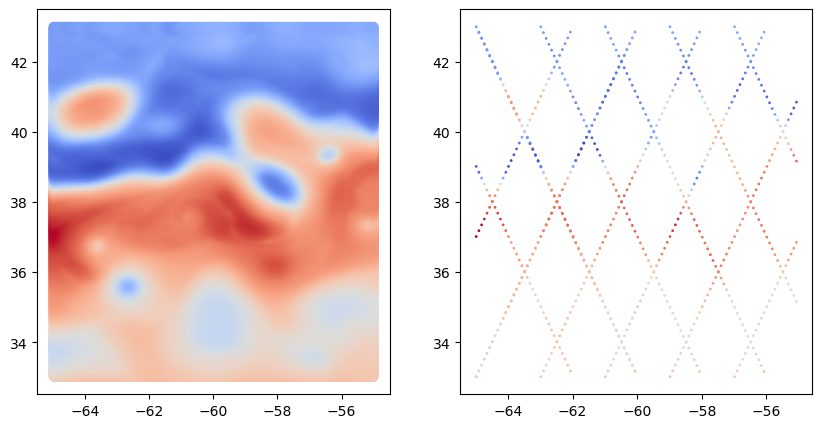

In [4]:
# plot simulation data against artificial satelite tracks
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

# make a meshgrid for the lon and lat values
lon, lat = np.meshgrid(ds.data.lon, ds.data.lat)
ax1.scatter(lon, lat, c = ds.data.sossheig.values, cmap = "coolwarm")

# plot the track
track_lon, track_lat, track_ssh = ds.generate_track(trajectory_gradient = 2, track_sparsity = 2, observation_sparisty = 10)
ax2.scatter(track_lon, track_lat, c = track_ssh, cmap = "coolwarm", s = 1)

In [5]:
# Training Data
X_train = torch.tensor(np.c_[track_lon, track_lat], dtype = torch.float64)
y_train = torch.tensor(track_ssh, dtype = torch.float64)

In [6]:
# get grid limits
print(f'Grid limits dim 1:  x1 min {X_train[:, 0].min().item()}, x1 max {X_train[:, 0].max().item()}')
print(f'Grid limits dim 2:  x2 min {X_train[:, 1].min().item()}, x2 max {X_train[:, 1].max().item()}')

Grid limits dim 1:  x1 min -64.98333333333419, x1 max -55.066666666668084
Grid limits dim 2:  x2 min 33.016666666666325, x2 max 42.99999999999909


In [7]:
# min max scaling
X_train[:, 0] = (X_train[:, 0] - X_train[:, 0].min()) / (X_train[:, 0].max() - X_train[:, 0].min())
X_train[:, 1] = (X_train[:, 1] - X_train[:, 1].min()) / (X_train[:, 1].max() - X_train[:, 1].min())

# Models

In [8]:
# parameters
N_B0_SPLINES = 20
DIM1_GRID_LIMS = (0, 1)
DIM2_GRID_LIMS = (0, 1)

## Exact GP

In [9]:
exactgp = GriddedMatern12ExactGP(
                        train_x = X_train, train_y = y_train,   
                        n_b0_splines = N_B0_SPLINES,
                        dim1_grid_lims = DIM1_GRID_LIMS, dim2_grid_lims = DIM2_GRID_LIMS,).to(torch.float64)

In [10]:
# fit the Exact GP
EXACT_GP_LR = 0.1
EXACT_GP_ITERATIONS = 100
# set model and likelihood into training mode
exactgp.train()
exactgp.likelihood.train()
# define the optimizer
optimizer = torch.optim.Adam(exactgp.parameters(), lr = EXACT_GP_LR)
# define the mll
mll = gpytorch.mlls.ExactMarginalLogLikelihood(exactgp.likelihood, exactgp)
history = torch.zeros(EXACT_GP_ITERATIONS)
for i in tqdm(range(EXACT_GP_ITERATIONS)):
    optimizer.zero_grad()
    output = exactgp(exactgp.train_x)
    loss = -mll(output, exactgp.train_y)
    history[i] = loss.item()
    loss.backward()
    optimizer.step()

# print('='*((5*15) + 4))
# print(f"{'Iteration':^15}|{'Loss':^15}|{'Noise':^15}|{'Lengthscale':^15}|{'Outputscale':^15}")
# print('='*((5*15) + 4))
# print(f"{i+1:^15}|{loss.item():^15.3f}|{exactgp.likelihood.noise.item():^15.3f}|{exactgp.kernel.base_kernel.lengthscale.item():^15.3f}|{exactgp.kernel.outputscale.item():^15.3f}")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 23.26it/s]


/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
/Users/maxnorman/UCL/dissertation/src/models/sparse/gridded_kronecker_structure.py:86: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343686209/work/aten/src/ATen/native/BucketizationUtils.h:35.)
  indicator = -torch.sign(torch.searchsorted(mesh, x[:, 0], right=False) - k[:, None] - 1)
/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/linear_oper

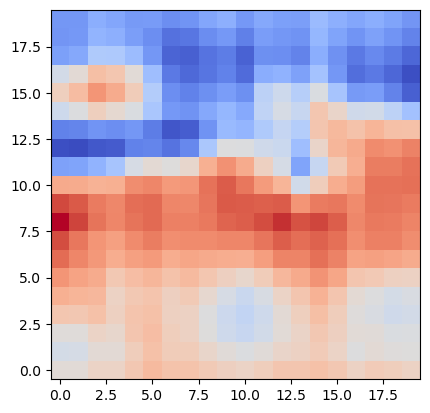

In [11]:
plt.imshow(exactgp.q_v().mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, origin='lower', cmap='coolwarm')

## SVGP

In [12]:
# inducing points
N_INDUCING = 100
Z = torch.tensor(np.random.rand(N_INDUCING, 2), dtype=torch.float64)

In [13]:
gridded_svgp = GriddedMatern12SVGP(
                    X_train.to(torch.float64), y_train.to(torch.float64), Z.to(torch.float64), # data part
                    n_b0_splines=N_B0_SPLINES, # vff part
                    dim1_grid_lims=DIM1_GRID_LIMS, dim2_grid_lims=DIM2_GRID_LIMS).to(torch.float64) # spline part

In [14]:
# fit the VFFGP
LR = 0.1
ITERATIONS = 100
optimizer = torch.optim.Adam(gridded_svgp.parameters(), lr=LR)
# perform gradient descent
svgp_history = torch.empty(ITERATIONS)
for i in tqdm(range(ITERATIONS)):
    optimizer.zero_grad()
    elbow = -gridded_svgp._elbo()
    svgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()
;

100%|██████████| 100/100 [00:09<00:00, 10.23it/s]


''

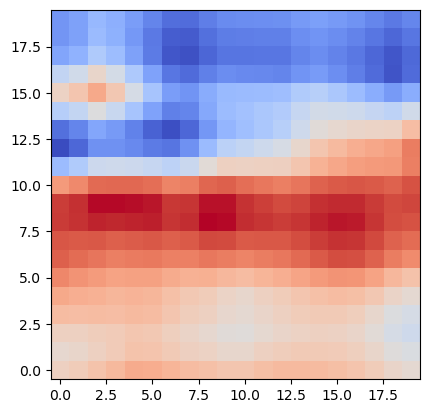

In [15]:
plt.imshow(gridded_svgp.q_v().mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, origin='lower', cmap='coolwarm')

## VFFGP

In [16]:
gridded_vffgp = GriddedMatern12VFFGP(
                    X_train, y_train, # data part
                    nfrequencies=10, vffdim1lims=(0., 2.), vffdim2lims=(0., 2.), # vff part
                    nsplines = N_B0_SPLINES, griddim1lims=DIM1_GRID_LIMS, griddim2lims=DIM2_GRID_LIMS).to(torch.float64) # spline part

In [17]:
# fit the VFFGP
LR = 0.1
ITERATIONS = 100
optimizer = torch.optim.Adam(gridded_vffgp.parameters(), lr=LR)
# perform gradient descent
svgp_history = torch.empty(ITERATIONS)
for i in tqdm(range(ITERATIONS)):
    optimizer.zero_grad()
    elbow = -gridded_vffgp._elbo()
    svgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()
;

100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


''

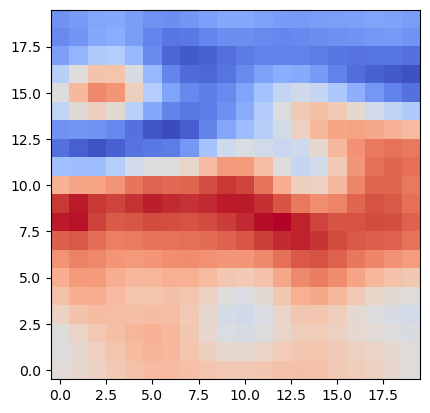

In [18]:
plt.imshow(gridded_vffgp.q_v().mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, origin='lower', cmap='coolwarm')

## ASVGP

In [39]:
N_B0SPLINES = 20
PADDING_FACTOR = 0
gridded_asvgp = GriddedMatern12ASVGP(X_train, y_train, N_B0SPLINES, PADDING_FACTOR, (0,1), (0,1))

In [41]:
# fit the VFFGP
LR = 0.1
ITERATIONS = 100
optimizer = torch.optim.Adam(gridded_asvgp.parameters(), lr=LR)
# perform gradient descent
gridded_asvgp_history = torch.empty(ITERATIONS)
for i in tqdm(range(ITERATIONS)):
    optimizer.zero_grad()
    elbow = -gridded_asvgp._elbo()
    gridded_asvgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()
;

100%|██████████| 100/100 [00:10<00:00,  9.12it/s]


''

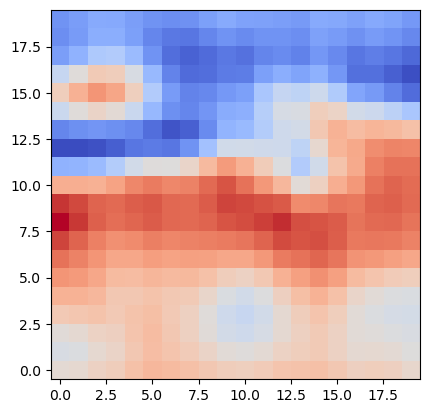

In [42]:
plt.imshow(gridded_asvgp.q_v().mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, origin='lower', cmap='coolwarm')

## GriddedGP (Mine)

In [43]:
griddedgp = Matern12GriddedGP(X_train, y_train, N_B0_SPLINES + 1, DIM1_GRID_LIMS, DIM2_GRID_LIMS).to(torch.float64)

In [44]:
# fit the VFFGP
LR = 0.1
ITERATIONS = 100
optimizer = torch.optim.Adam(griddedgp.parameters(), lr=LR)
# perform gradient descent
griddedgp_history = torch.empty(ITERATIONS)
for i in tqdm(range(ITERATIONS)):
    optimizer.zero_grad()
    elbow = -griddedgp._elbo()
    griddedgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()
;

100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


''

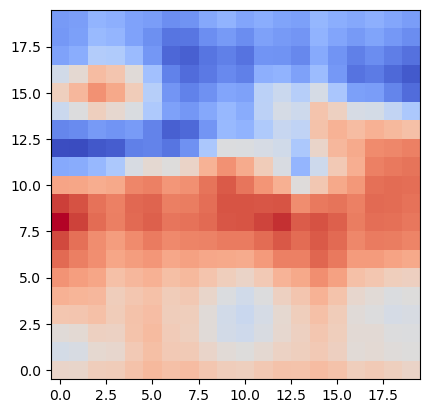

In [45]:
plt.imshow(griddedgp.q_v().mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, origin='lower', cmap='coolwarm')

# Model Comparison

In [46]:
# get the q(v)s
exactgp_grid_pred = exactgp.q_v()
svgp_grid_pred = gridded_svgp.q_v()
vffgp_grid_pred = gridded_vffgp.q_v()
asvgp_grid_pred = gridded_asvgp.q_v()
griddedgp_grid_pred = griddedgp.q_v()

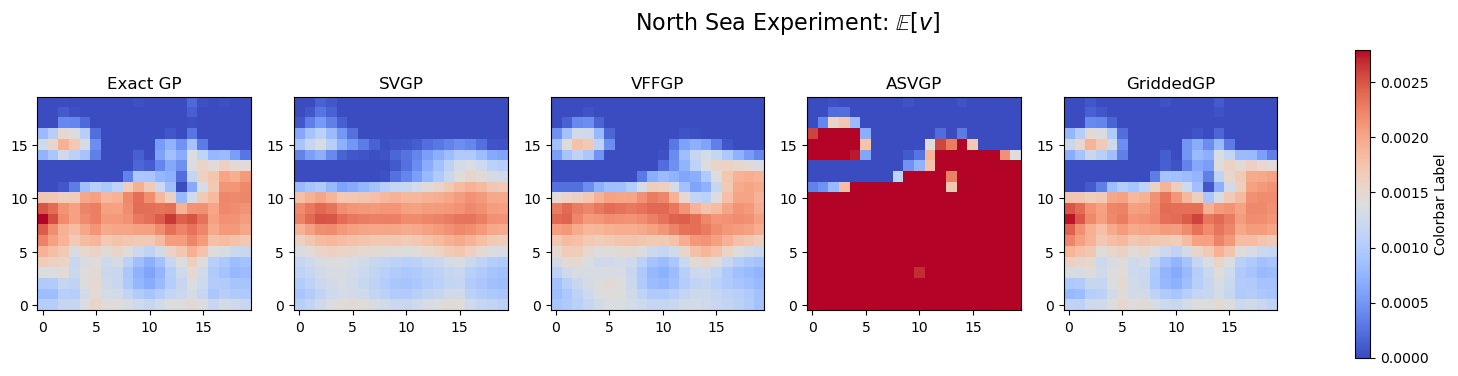

In [65]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))

# exact GP
ax1.set_title('Exact GP')
im1 = ax1.imshow(exactgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, cmap='coolwarm', origin='lower', vmin=0, vmax=0.0028)

# SVGP
ax2.set_title('SVGP')
im2 = ax2.imshow(svgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, cmap='coolwarm', origin='lower', vmin=0, vmax=0.0028)

# VFFGP
ax3.set_title('VFFGP')
im3 = ax3.imshow(vffgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, cmap='coolwarm', origin='lower', vmin=0, vmax=0.0028)

# ASVGP
ax4.set_title('ASVGP')
im4 = ax4.imshow(asvgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, cmap='coolwarm', origin='lower', vmin=0, vmax=0.0028)

# GriddedGP
ax5.set_title('GriddedGP')
im5 = ax5.imshow(griddedgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, cmap='coolwarm', origin='lower', vmin=0, vmax=0.0028)

plt.suptitle(r'North Sea Experiment: $\mathbb{E}[v]$', fontsize=16)
cbar = fig.colorbar(im1, ax=[ax1, ax2, ax3, ax4, ax5])
cbar.set_label('Colorbar Label')

In [ ]:
exactgp_grid_pred = exactgp.q_v()
svgp_grid_pred = gridded_svgp.q_v()
vffgp_grid_pred = gridded_vffgp.q_v()
asvgp_grid_pred = gridded_asvgp.q_v()
griddedgp_grid_pred = griddedgp.q_v()

In [57]:
max_vals = [exactgp_grid_pred.mean.detach().numpy().max(),
            svgp_grid_pred.mean.detach().numpy().max(),
            vffgp_grid_pred.mean.detach().numpy().max(),
            asvgp_grid_pred.mean.detach().numpy().max(),
            griddedgp_grid_pred.mean.detach().numpy().max(),
            ]

In [60]:
min_vals = [exactgp_grid_pred.mean.detach().numpy().min(),
            svgp_grid_pred.mean.detach().numpy().min(),
            vffgp_grid_pred.mean.detach().numpy().min(),
            asvgp_grid_pred.mean.detach().numpy().min(),
            griddedgp_grid_pred.mean.detach().numpy().min(),
            ]

In [61]:
min_vals

[-0.0008949737051171212,
 -0.0006161021847997584,
 -0.0007272136145605136,
 -0.0032456570928065965,
 -0.0009145439798974847]